## Forecasting in the M4 Competition

This tutorial demonstrates how to quickly start using AutoGluon to generate hourly forecasts for the M4 forecasting competition. Also check out the AutoGluon-TimeSeries [cheat sheet](https://auto.gluon.ai/stable/cheatsheet.html#time-series).

In [ ]:
#!pip install autogluon==0.6.1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

To use autogluon.timeseries, we will only need the following two classes:

- `TimeSeriesDataFrame` stores a dataset consisting of multiple time series.
- `TimeSeriesPredictor` takes care of fitting, tuning and selecting the best forecasting models, as well as generating new forecasts.

We will first read the data into a pandas data frame and then load it in a `TimeSeriesDataFrame` to use AutoGluon-TimeSeries.

In [2]:
df = pd.read_csv(
    "https://autogluon-timeseries-datasets.s3.us-west-2.amazonaws.com/public/m4_daily/m4_daily_subsample.csv",
    parse_dates=["Date"],  # make sure that pandas parses the dates
)
df

,M4id,Date,Value
0,D1737,1995-05-23 12:00:00,1900.0
1,D1737,1995-05-24 12:00:00,1877.0
2,D1737,1995-05-25 12:00:00,1873.0
3,D1737,1995-05-26 12:00:00,1859.0
4,D1737,1995-05-27 12:00:00,1876.0
...,...,...,...
244455,D2345,2013-07-04 12:00:00,10391.5
244456,D2345,2013-07-05 12:00:00,10361.4
244457,D2345,2013-07-06 12:00:00,10285.4
244458,D2345,2013-07-07 12:00:00,10135.9


The M4 dataset contains time series from various domains like finance, demography and economics.
Our goal is to forecast the future values of each time series in the dataset given the past observations.
Each row of the data frame contains a single observation (timestep) of a single time series represented by
- unique ID of the time series (`"M4id"`)
- timestamp of the observation (`"Date"`) as a `pandas.Timestamp`
- numeric value of the time series (`"Value"`)


The raw dataset should always follow this format with at least three columns for unique ID, timestamp, and target value, but the names of these columns can be arbitrary.
It is important, however, that we provide the names of the columns when constructing a `TimeSeriesDataFrame` that is used by AutoGluon.
AutoGluon will raise an exception if the data doesn't match the expected format.


In [3]:
ts_dataframe = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="M4id",  # column that contains unique ID of each time series
    timestamp_column="Date",  # column that contains timestamps of each observation
)
ts_dataframe

Value
item_id timestamp                   
D1737   1995-05-23 12:00:00   1900.0
        1995-05-24 12:00:00   1877.0
        1995-05-25 12:00:00   1873.0
        1995-05-26 12:00:00   1859.0
        1995-05-27 12:00:00   1876.0
...                              ...
D2345   2013-07-04 12:00:00  10391.5
        2013-07-05 12:00:00  10361.4
        2013-07-06 12:00:00  10285.4
        2013-07-07 12:00:00  10135.9
        2013-07-08 12:00:00  10201.5

[244460 rows x 1 columns]

We refer to each individual time series stored in a `TimeSeriesDataFrame` as an _item_.
For example, items might correspond to different products in demand forecasting, or to different stocks in financial datasets.
This setting is also referred to as a _panel_ of time series.
Note that this is *not* the same as multivariate forecasting — AutoGluon generates forecasts for each time series individually, without modeling interactions between different items (time series).

`TimeSeriesDataFrame` inherits from [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), so all attributes and methods of `pandas.DataFrame` are also available in a `TimeSeriesDataFrame`.
Note how `TimeSeriesDataFrame` organizes the data with a `pandas.MultiIndex`: the first _level_ of the index corresponds to the item ID and the second level contains the timestamp when each observation was made.
For example, we can use the `loc` accessor to access each individual time series.

In [4]:
ts_dataframe.loc["D185"].head()

,Value
timestamp,
1984-03-23 12:00:00,6281.25
1984-03-24 12:00:00,6309.38
1984-03-25 12:00:00,6300.00
1984-03-26 12:00:00,6293.75
1984-03-27 12:00:00,6325.00


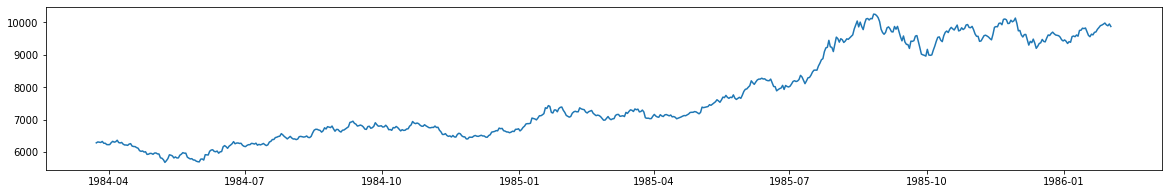

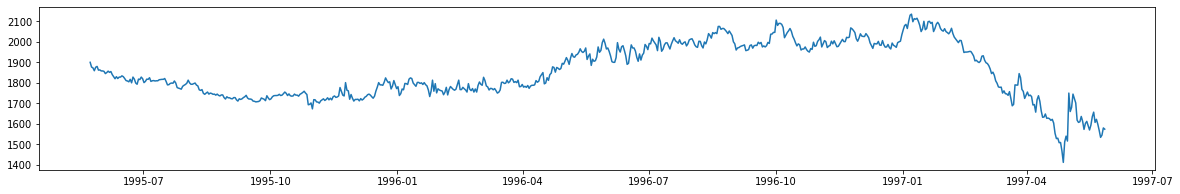

In [5]:
for item_id in ["D185", "D1737"]:
    plt.figure(figsize=(20, 3))
    plt.plot(ts_dataframe.loc[item_id], label=item_id)


## Forecasting problem formulation
Models in `autogluon.timeseries` provide _probabilistic_ forecasts of time series _multiple steps_ into the future.
We choose the number of these steps---the _prediction length_ (also known as the _forecast horizon_) depending on our task.
For example, our dataset contains time series measured at hourly _frequency_, so we set `prediction_length = 48` to train models that forecast 48 hours into the future.
Moreover, forecasts are probabilistic: in addition to predicting the _mean_ (expected value) of the time series in the future, models also provide the _quantiles_ of the forecast distribution.

In order to report realistic results for how AutoGluon will perform on unseen data; we will split our dataset into a training set, used to train & tune models, and a test set used to evaluate the final performance.
In forecasting, this is usually done by hiding the last `prediction_length` steps of each time series during training, and only using these last steps to evaluate the forecast quality (also known as "out of time validation").
We perform this split using the `slice_by_timestep` method of `TimeSeriesDataFrame`.


In [6]:
prediction_length = 48

test_data = ts_dataframe  # the full data set

# last prediction_length timesteps of each time series are excluded, akin to `x[:-48]`
train_data = ts_dataframe.slice_by_timestep(None, -prediction_length)

Below, we plot the training and test parts of the time series for a single item, and mark the test forecast horizon.
We will compute the test scores by measuring how well the forecast generated by a model matches the actually observed values in the forecast horizon.


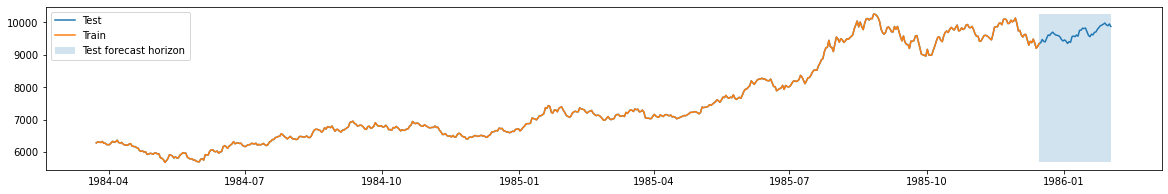

In [7]:
item_id = "D185"
plt.figure(figsize=(20, 3))
train_series = train_data.loc[item_id]["Value"]
test_series = test_data.loc[item_id]["Value"]
plt.plot(test_series, label="Test")
plt.plot(train_series, label="Train")

plt.fill_betweenx(
    y=(test_series.min(), test_series.max()),
    x1=train_series.index[-1],
    x2=test_series.index[-1],
    alpha=0.2,
    label="Test forecast horizon",
)

plt.legend();


## Training time series models with `TimeSeriesPredictor.fit`

Below we instantiate a `TimeSeriesPredictor` object and instruct AutoGluon to fit models that can forecast up to
48 timesteps into the future (`prediction_length`) and save them in the folder `./autogluon-m4-hourly`.
We also specify that AutoGluon should rank models according to mean absolute percentage error (MAPE), and that data that we want to forecast is stored in the column `"Value"` of the `TimeSeriesDataFrame`.


In [ ]:
predictor = TimeSeriesPredictor(
    path="autogluon-m4-hourly",
    target="Value",
    prediction_length=prediction_length,
    eval_metric="MAPE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'prediction_length': 48,
 'random_seed': None,
 'target': 'Value',
 'time_limit': 600}
Provided training data set with 239660 rows, 100 items (item = single time series). Average time series length is 2396.6.
Training artifacts will be saved to: /local/home/atturkm/workplace/ws_autogluon/scripts/autogluon-m4-hourly
AutoGluon will save models to autogluon-m4-hourly/
AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.
tuning_data is None. Will use the last prediction_length = 48 time steps of each time series as a hold-out validation set.

Starting t

Here we used the `"medium_quality"` presets and limited the training time to 10 minutes (600 seconds).
The presets define which models AutoGluon will try to fit.
For `medium_quality` presets, these are 
- simple baselines (`Naive`, `SeasonalNaive`), 
- statistical models (`ARIMA`, `ETS`, `Theta`), 
- tree-based models XGBoost, LightGBM and CatBoost wrapped by `AutoGluonTabular`,
- a deep learning model `DeepAR`,
- and a weighted ensemble combining these.
Other available presets for `TimeSeriesPredictor` are `"fast_training"` `"high_quality"` and `"best_quality"`.
Higher quality presets will usually produce more accurate forecasts but take longer to train and may produce less computationally efficient models.

Inside `fit()`, AutoGluon will train as many models as possible within the given time limit.
Trained models are then ranked based on their performance on an internal validation set.
By default, this validation set is constructed by holding out the last `prediction_length` timesteps of each time series in `train_data`.


## Evaluating the performance of different models

We can view the test performance of each model AutoGluon has trained via the `leaderboard()` method.
We provide the test data set to the leaderboard function to see how well our fitted models are doing on the held out test data.
The leaderboard also includes the validation scores computed on the internal validation dataset.

In AutoGluon leaderboards, higher scores always correspond to better predictive performance.
Therefore our MAPE scores are multiplied by `-1`, such that higher "negative MAPE"s correspond to more accurate forecasts.


In [ ]:
predictor.leaderboard(test_data, silent=True)

## Generating forecasts with `TimeSeriesPredictor.predict`

We can now use the fitted `TimeSeriesPredictor` to make predictions.
By default, AutoGluon will make forecasts using the model that had the best validation score (as shown in the leaderboard).
Let's use the predictor to generate forecasts starting from the end of the time series in `train_data`

In [ ]:
predictions = predictor.predict(train_data)
predictions.head()

Predictions are also stored as a `TimeSeriesDataFrame`. However, now the columns contain the mean and quantile predictions of each model.
The quantile forecasts give us an idea about the range of possible outcomes.
For example, if the `"0.1"` quantile is equal to `501.3`, it means that the model predicts a 10% chance that the target value will be below `501.3`.

We will now visualize the forecast and the actually observed values for one of the time series in the dataset.
We plot the mean forecast, as well as the 10% and 90% quantiles to show the range of potential outcomes.

In [ ]:
plt.figure(figsize=(20, 3))

item_id = "D185"
y_past = train_data.loc[item_id]["Value"]
y_pred = predictions.loc[item_id]
y_true = test_data.loc[item_id]["Value"][-prediction_length:]

# prepend the last value of true range to predicted range for plotting continuity
y_pred.loc[y_past.index[-1]] = [y_past[-1]] * 10
y_pred = y_pred.sort_index()

plt.plot(y_past[-200:], label="Training data")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_true, label="Observed")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.title("Forecasted time series values vs. the real observations")
plt.legend();
